# Keras and Autoencoder

This code is based on this notebook https://github.com/naokishibuya/deep-learning/blob/master/python/autoencoder_noise_reduction.ipynb



In [1]:
import numpy as np
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## MNIST

Database for handwritten digits made by Yann Lecun

In [2]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

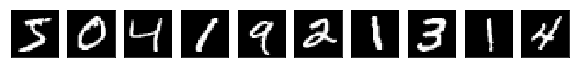

In [3]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
def preprocess(x):
    x = x.astype('float32') / 255.
    return x.reshape(-1, np.prod(x.shape[1:])) # flatten

X_train = preprocess(X_train)
X_test  = preprocess(X_test)

# also create a validation set for training
X_train, X_valid = train_test_split(X_train, test_size=0.3)

## Convolutional Autoencoder

Here we are going to define our model

In [5]:
def convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling2D(padding='same')(x)    
    
    # decoding
    x = Conv2D( 8, 3, activation='relu', padding='same')(encoded)
    x = UpSampling2D()(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = Conv2D(16, 3, activation='relu')(x)
    x = UpSampling2D()(x)
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)    
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.summary()
    
    return autoencoder

def get_callbacks(model_filepath, log_dir, patience=10):
    earlystopping = EarlyStopping('val_loss', patience=patience, mode="min")
    checkpointer = ModelCheckpoint(filepath=model_filepath,
                               verbose=0,
                               save_best_only=True)
    tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=0,
                              write_graph=True,
                              write_images=True)
    return [earlystopping, checkpointer, tensorboard]

file_path_feed_forward = ".model_weights_conv_autoe.hdf5"
log_dir_feed_forward = './logs/conv_autoe'
callbacks_feed_forward = get_callbacks(file_path_feed_forward, log_dir_feed_forward, patience=10)

Before anything, we need reshape our data to the format that our model expects.

In [6]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

In [7]:
autoencoder = convolutional_autoencoder()
autoencoder.fit(
    X_train, X_train, 
    epochs=50, 
    batch_size=128, 
    validation_data=(X_valid, X_valid), 
    callbacks=callbacks_feed_forward
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [8]:
def show_images(before_images, after_images):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # before
        plt.subplot(2, 10, i+1)
        plt.imshow(before_images[i].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(after_images[i].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

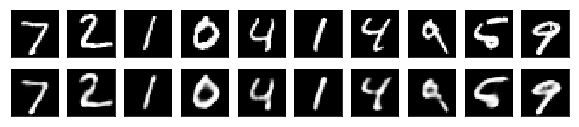

In [9]:
X_test_decoded = autoencoder.predict(X_test)

show_images(X_test, X_test_decoded)

In [10]:
def add_noise(x, noise_factor=0.2):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
    
X_train_noisy = add_noise(X_train, 0.5)
X_valid_noisy = add_noise(X_valid, 0.5)
X_test_noisy  = add_noise(X_test, 0.5)

In [11]:
noise_autoencoder = convolutional_autoencoder()
noise_autoencoder.fit(X_train_noisy, X_train, epochs=50, batch_size=128, validation_data=(X_valid_noisy, X_valid))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0         
__________

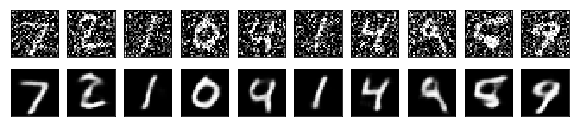

In [12]:
X_test_decoded = noise_autoencoder.predict(X_test_noisy)

show_images(X_test_noisy, X_test_decoded)